In [ ]:
!pip install vaderSentiment
!pip install transformers==4.23.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.1
    Uninstalling transformers-4.38.1:
      Successfully uninstalled transformers-4.38.1


In [ ]:
from google.colab import drive

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import nltk
from nltk import tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, TrainingArguments, Trainer, DistilBertConfig, DistilBertForSequenceClassification, BertConfig

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cpu


In [ ]:
# Mount Google Drive
drive.mount('/content/gdrive')

# Define the file path
path = "/content/gdrive/MyDrive/Advanced ML/full_model_cluster_info.csv"

# Load data
clusters = pd.read_csv(path)

Mounted at /content/gdrive


In [ ]:
clusters[:1]

,Topic,Count,Name,Representation,Representative_Docs
0,-1,11736,-1_the_and_in_to,"['the', 'and', 'in', 'to', 'of', 'on', 'that',...",['report: doj opened separate probe into hunte...


In [ ]:
# Define the file path
path = "/content/gdrive/MyDrive/Advanced ML/full_model_documents_classified.csv"

# Load data
articles = pd.read_csv(path)
articles = articles[articles['Topic'] != -1] # drop cluster which is not meaningful

In [ ]:
len(articles)

25308

Representative Articles

In [ ]:
# rep_articles = articles[articles['Representative_document'] == True]
# rep_articles[:2]

In [ ]:
# rep_articles.groupby('Topic').size() # clusters too small to only look at representative articles

### Classify Sentiment

In [ ]:
articles.columns

Index(['Document', 'Topic', 'Name', 'Representation', 'Representative_Docs',
       'Top_n_words', 'Probability', 'Representative_document'],
      dtype='object')

In [ ]:
articles[:1]

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
1,"iran paid bounties for targeting us troops, in...",172,172_bounties_bounty_russia_intelligence,"['bounties', 'bounty', 'russia', 'intelligence...",[' james inhofe vows ‘strong response...,bounties - bounty - russia - intelligence - ru...,0.391835,False


Calculate sentiment score with VADER

In [ ]:
def calculate_average_sentiment(paragraph): # adding to Jackie's function
    analyzer = SentimentIntensityAnalyzer()
    # create sentence list
    sentence_list = tokenize.sent_tokenize(paragraph)
    #print(len(sentence_list),sentence_list)
    paragraph_sentiments = 0.0
    for sentence in sentence_list:
        vs = analyzer.polarity_scores(sentence)
        paragraph_sentiments += vs["compound"]

    # the average sentiment
    average_sentiment = paragraph_sentiments / len(sentence_list)
    return round(average_sentiment, 4)


In [ ]:
articles['vader_cont_sentiment_score'] = articles['Document'].apply(calculate_average_sentiment)

In [ ]:
articles = articles[articles['vader_cont_sentiment_score'].notna()]

Classify VADER SCORE into 5 categories

In [ ]:
def categorize_vader_sentiment(average_sentiment):
    if average_sentiment >= 0.5:
        return 5
    elif average_sentiment >= 0.3:
        return 4
    elif average_sentiment <= -0.5:
        return 2
    elif average_sentiment <= -0.3:
        return 1
    else:
        return 3

In [ ]:
articles['vader_sentiment_score'] = articles['vader_cont_sentiment_score'].apply(categorize_vader_sentiment)

In [ ]:
articles[:1]

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,vader_cont_sentiment_score,vader_sentiment_score
1,"iran paid bounties for targeting us troops, in...",172,172_bounties_bounty_russia_intelligence,"['bounties', 'bounty', 'russia', 'intelligence...",[' james inhofe vows ‘strong response...,bounties - bounty - russia - intelligence - ru...,0.391835,False,0.5243,5


Classify text with BERT model

In [ ]:
# To reload a saved model
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model_save_directory =  "/content/gdrive/MyDrive/model_save_directory/title_text_sentiment_bert_1000"
model = DistilBertForSequenceClassification.from_pretrained(model_save_directory)
print(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
def bert_sentiment(text, tokenizer, model):

  # Tokenize the new text
  inputs = tokenizer(text, return_tensors='pt')

  # Move input tensors to the same device as the model
  inputs = {key: value.to(model.device) for key, value in inputs.items()}

  # Forward pass through the trained model
  with torch.no_grad():
      outputs = model(**inputs)

  # Get predicted probabilities and labels
  probs = torch.softmax(outputs.logits, dim=-1)
  predicted_class = torch.argmax(probs)

  return predicted_class.item() + 1 # add one to standardize to 5 point scale

In [ ]:
articles['bert_sentiment_score'] = articles['Document'].apply(lambda x: bert_sentiment(x, tokenizer, model))

In [ ]:
articles[:2]

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,vader_cont_sentiment_score,vader_sentiment_score,...,full_article_text_y,title_text_y,Unnamed: 0,uuid,source,year,article_text,title,full_article_text,title_text


In [ ]:
articles_path = "/content/gdrive/MyDrive/Advanced ML/full_model_documents_classified.csv"
articles.to_csv(articles_path)

### Clusters
Clusters to analyze = 1, 4, 9, 13, 17, 20, 22, 27

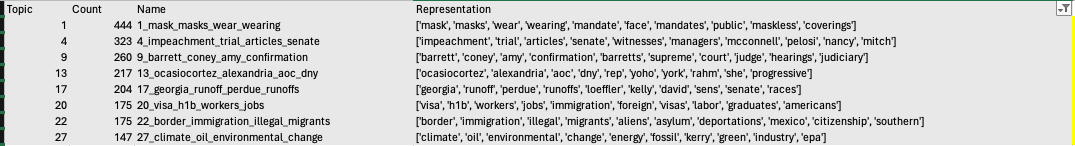

In [ ]:
articles[:1]

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,vader_cont_sentiment_score,vader_sentiment_score,bert_sentiment_score
1,"iran paid bounties for targeting us troops, in...",172,172_bounties_bounty_russia_intelligence,"['bounties', 'bounty', 'russia', 'intelligence...",[' james inhofe vows ‘strong response...,bounties - bounty - russia - intelligence - ru...,0.391835,False,0.5243,5,3


Load CSV

In [ ]:
# Mount Google Drive
drive.mount('/content/gdrive')

# Define the file path
path = "/content/gdrive/MyDrive/Advanced ML/full_model_documents_classified.csv"

# Load data
articles_classified = pd.read_csv(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
articles_classified[:5]

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,...,year_x,article_text_x,title_x,title_text_x,uuid_y,source_y,year_y,article_text_y,title_y,title_text_y
0,0,0,1,"iran paid bounties for targeting us troops, in...",172,172_bounties_bounty_russia_intelligence,"['bounties', 'bounty', 'russia', 'intelligence...",[' james inhofe vows ‘strong response...,bounties - bounty - russia - intelligence - ru...,0.391835,...,2020,u.s. intelligence reportedly indicates iran’s ...,"iran paid bounties for targeting us troops, in...","iran paid bounties for targeting us troops, in...",cfb4ce29-406e-11ee-a96e-33dec8f414a2,wp,2020,u.s. intelligence reportedly indicates iran’s ...,"iran paid bounties for targeting us troops, in...","iran paid bounties for targeting us troops, in..."
1,1,1,3,"trump slams relief bill, calls on congress to ...",2,2_relief_package_stimulus_trillion,"['relief', 'package', 'stimulus', 'trillion', ...",['house passes $3 trillion coronavirus relief ...,relief - package - stimulus - trillion - bill ...,1.000000,...,2020,president trump on tuesday evening blasted con...,"trump slams relief bill, calls on congress to ...","trump slams relief bill, calls on congress to ...",e7b340f7-406e-11ee-a96e-33dec8f414a2,thehill,2020,president trump on tuesday evening blasted con...,"trump slams relief bill, calls on congress to ...","trump slams relief bill, calls on congress to ..."
2,2,2,4,naomi osaka withdraws from french open to focu...,1,1_mask_masks_wear_wearing,"['mask', 'masks', 'wear', 'wearing', 'mandate'...","['donald trump: wear a mask, they have an impa...",mask - masks - wear - wearing - mandate - face...,0.213468,...,2020,japanese tennis star naomi osaka has withdrawn...,naomi osaka withdraws from french open to focu...,naomi osaka withdraws from french open to focu...,a43934fc-411f-11ee-a96e-33dec8f414a2,thehill,2020,japanese tennis star naomi osaka has withdrawn...,naomi osaka withdraws from french open to focu...,naomi osaka withdraws from french open to focu...
3,3,3,5,u.s. steelworkers get largest wage hike in yea...,20,20_visa_h1b_workers_jobs,"['visa', 'h1b', 'workers', 'jobs', 'immigratio...",['trump extends order halting visas to priorit...,visa - h1b - workers - jobs - immigration - fo...,0.252907,...,2020,president trump’s tariffs on imported aluminum...,u.s. steelworkers get largest wage hike in yea...,u.s. steelworkers get largest wage hike in yea...,a56a2504-411f-11ee-a96e-33dec8f414a2,breitbart,2020,president trump’s tariffs on imported aluminum...,u.s. steelworkers get largest wage hike in yea...,u.s. steelworkers get largest wage hike in yea...
4,4,4,6,west virginia gov. jim justice endorses trump ...,53,53_bader_ruth_ginsburg_ginsburgs,"['bader', 'ruth', 'ginsburg', 'ginsburgs', 'su...",[' trump vows to pick woman for supre...,bader - ruth - ginsburg - ginsburgs - supreme ...,0.741817,...,2020,republican west virginia gov. jim justice endo...,west virginia gov. jim justice endorses trump ...,west virginia gov. jim justice endorses trump ...,31e2bd55-3da2-11ee-a96e-33dec8f414a2,dailycaller,2020,republican west virginia gov. jim justice endo...,west virginia gov. jim justice endorses trump ...,west virginia gov. jim justice endorses trump ...


In [ ]:
# Define the file path
path = "/content/gdrive/MyDrive/Advanced ML/metadata_w_2020articles_cleaned.csv"

# Load data
articles_info = pd.read_csv(path)

In [ ]:
articles_info[:5]

,Unnamed: 0,uuid,source,year,article_text,title,title_text
0,0,bcbc6bb2-406e-11ee-a96e-33dec8f414a2,wp,2020,president trump on monday said he was “proud” ...,"trump shifts tone, says he’s ‘proud’ of fed am...","trump shifts tone, says he’s ‘proud’ of fed am..."
1,1,cfb4ce29-406e-11ee-a96e-33dec8f414a2,wp,2020,u.s. intelligence reportedly indicates iran’s ...,"iran paid bounties for targeting us troops, in...","iran paid bounties for targeting us troops, in..."
2,2,db9f408f-406e-11ee-a96e-33dec8f414a2,wp,2020,u.s. forces have rescued an american citizen h...,us forces rescue american citizen held hostage...,us forces rescue american citizen held hostage...
3,3,e7b340f7-406e-11ee-a96e-33dec8f414a2,thehill,2020,president trump on tuesday evening blasted con...,"trump slams relief bill, calls on congress to ...","trump slams relief bill, calls on congress to ..."
4,4,a43934fc-411f-11ee-a96e-33dec8f414a2,thehill,2020,japanese tennis star naomi osaka has withdrawn...,naomi osaka withdraws from french open to focu...,naomi osaka withdraws from french open to focu...


In [ ]:
articles = pd.merge(articles_classified, articles_info, left_on='Unnamed: 0', right_on='Unnamed: 0', how='inner')

In [ ]:
articles_classified.drop(columns=(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'uuid_y',
'source_y', 'year_y', 'article_text_y', 'title_y', 'title_text_y']), inplace=True)

In [ ]:
articles_classified[:1]

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,vader_cont_sentiment_score,vader_sentiment_score,bert_sentiment_score,uuid_x,source_x,year_x,article_text_x,title_x,title_text_x
0,"iran paid bounties for targeting us troops, in...",172,172_bounties_bounty_russia_intelligence,"['bounties', 'bounty', 'russia', 'intelligence...",[' james inhofe vows ‘strong response...,bounties - bounty - russia - intelligence - ru...,0.391835,False,0.5243,5,3,cfb4ce29-406e-11ee-a96e-33dec8f414a2,wp,2020,u.s. intelligence reportedly indicates iran’s ...,"iran paid bounties for targeting us troops, in...","iran paid bounties for targeting us troops, in..."


BERT Labels

In [ ]:
bert_len = len(articles_classified['bert_sentiment_score'])

In [ ]:
# Get counts for each unique value in the 'Category' column
value_counts = articles_classified['bert_sentiment_score'].value_counts()

# Create a new DataFrame to represent the table
table_df = pd.DataFrame({'BERT Sentiment Score': value_counts.index, 'Count': value_counts.values})
table_df['Percentage'] = (table_df['Count']/bert_len).round(4)

# Display the resulting table
table_df

,BERT Sentiment Score,Count,Percentage
0,3,17483,0.6908
1,1,2921,0.1154
2,4,2381,0.0941
3,2,1417,0.0560
4,5,1106,0.0437


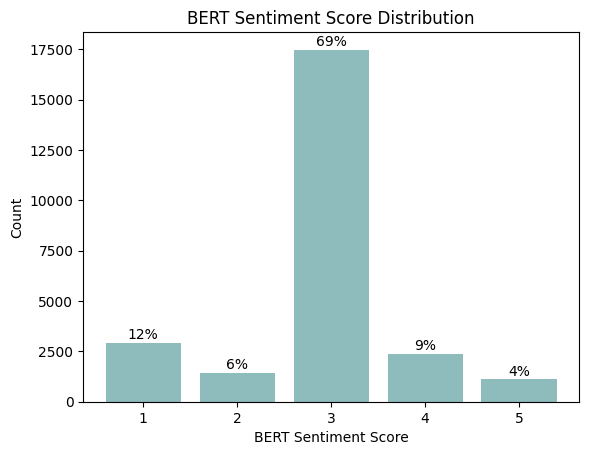

In [ ]:
# Create a bar chart
plt.bar(table_df['BERT Sentiment Score'], table_df['Count'], color='cadetblue', alpha=0.7, label='Count')
plt.xlabel('BERT Sentiment Score')
plt.ylabel('Count')
plt.title('BERT Sentiment Score Distribution')

# Add percentage labels to each bar
for i, val in enumerate(table_df['Percentage']):
    plt.text(table_df['BERT Sentiment Score'][i], table_df['Count'][i] + 50, f'{val:.0%}', ha='center', va='bottom')

# Show the plot
plt.show()

Vader Classification

In [ ]:
# Get counts for each unique value in the 'Category' column
value_counts = articles_classified['vader_sentiment_score'].value_counts()

# Create a new DataFrame to represent the table
table_df = pd.DataFrame({'VADER Sentiment Score': value_counts.index, 'Count': value_counts.values})
table_df['Percentage'] = (table_df['Count']/len(articles_classified)).round(4)

# Display the resulting table
table_df

,VADER Sentiment Score,Count,Percentage
0,3,11220,0.4433
1,2,4237,0.1674
2,5,4113,0.1625
3,4,3023,0.1194
4,1,2715,0.1073


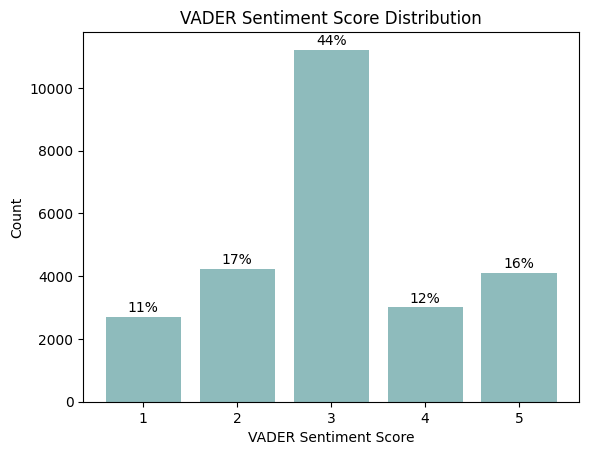

In [ ]:
# Create a bar chart
plt.bar(table_df['VADER Sentiment Score'], table_df['Count'], color='cadetblue', alpha=0.7, label='Count')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Count')
plt.title('VADER Sentiment Score Distribution')

# Add percentage labels to each bar
for i, val in enumerate(table_df['Percentage']):
    plt.text(table_df['VADER Sentiment Score'][i], table_df['Count'][i] + 50, f'{val:.0%}', ha='center', va='bottom')

# Show the plot
plt.show()

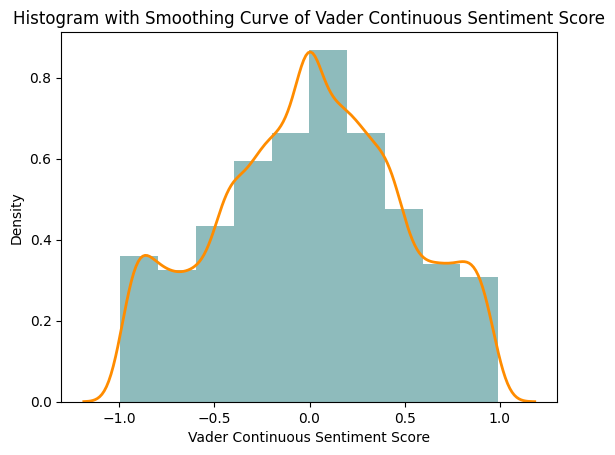

In [ ]:
plt.hist(articles_classified['vader_cont_sentiment_score'], color='cadetblue', density=True, alpha=0.7)  # You can adjust the number of bins as needed
sns.kdeplot(articles_classified['vader_cont_sentiment_score'], color='darkorange', linewidth=2)
plt.xlabel('Vader Continuous Sentiment Score')  # You can customize the label based on your data
plt.ylabel('Density')  # You can customize the label based on your data
plt.title('Histogram with Smoothing Curve of Vader Continuous Sentiment Score')
plt.show()

In [240]:
articles_classified['vader_cont_sentiment_score'].mean()

0.00020880749170222915

In [239]:
len(articles_classified)

25308

In [246]:
clusters = articles_classified.groupby(['Topic', 'Name'])['vader_cont_sentiment_score'].agg(['mean', 'count']).reset_index()
clusters.columns = ['Topic', 'Name', 'Average', 'Count']
clusters

,Topic,Name,Average,Count
0,0,0_facebook_twitter_tech_google,-0.132799,664
1,1,1_mask_masks_wear_wearing,0.034672,444
2,2,2_relief_package_stimulus_trillion,0.210825,420
3,3,3_abortion_prolife_parenthood_abortions,0.190003,352
4,4,4_impeachment_trial_articles_senate,-0.080780,323
...,...,...,...,...
539,539,539_cancel_culture_rowling_jk,-0.180220,10
540,540,540_haaland_deb_interior_native,0.397210,10
541,541,541_austin_dallas_abbott_texas,-0.344300,10
542,542,542_carter_page_rosenstein_surveillance,0.124960,10


In [241]:
clusters['Average'].mean()

-0.004429147300940058

In [242]:
clusters['Average'].median()

0.008974346405228761

In [249]:
clusters.sort_values('Average').head(5)

,Topic,Name,Average,Count
507,507,507_fraud_montenegro_charged_8000,-0.726767,12
34,34,34_alien_illegal_charged_arrested,-0.721853,133
61,61,61_shot_lightfoots_chicago_fatally,-0.714301,92
303,303,303_terror_islamic_terrorist_refugee,-0.647791,23
126,126,126_suspect_homeowner_shot_allegedly,-0.625388,52


In [250]:
clusters.sort_values('Average', ascending=False).head(5)

,Topic,Name,Average,Count
478,478,478_barrett_oath_clarence_ceremony,0.774800,13
535,535,535_medal_cashe_alwyn_honor,0.602650,10
513,513,513_usmca_nafta_trade_agreement,0.596100,11
428,428,428_roberts_chief_impeachment_trial,0.525480,15
108,108,108_ginsburg_bader_ruth_justice,0.521327,59


In [245]:
articles_classified.columns

Index(['Document', 'Topic', 'Name', 'Representation', 'Representative_Docs',
       'Top_n_words', 'Probability', 'Representative_document',
       'vader_cont_sentiment_score', 'vader_sentiment_score',
       'bert_sentiment_score', 'uuid_x', 'source_x', 'year_x',
       'article_text_x', 'title_x', 'title_text_x'],
      dtype='object')

### AOC Cluster

In [ ]:
aoc = articles_classified[articles_classified['Topic'] == 13]

In [ ]:
# Get counts for each unique value in the 'Category' column
vader_value_counts = aoc['vader_sentiment_score'].value_counts()
bert_value_counts = aoc['bert_sentiment_score'].value_counts()

# Create a new DataFrame to represent the table
table_df = pd.DataFrame({'VADER Sentiment Score': vader_value_counts.index, 'VADER Count': vader_value_counts.values})
table_df['VADER Percentage'] = (table_df['VADER Count']/len(articles_classified)).round(4)

table_df['BERT Sentiment Score'] = bert_value_counts.index
table_df['BERT Count'] = bert_value_counts.values
table_df['BERT Percentage'] = (table_df['BERT Count']/len(articles_classified)).round(4)


# Display the resulting table
table_df = table_df.sort_values(by='VADER Sentiment Score')
table_df

,VADER Sentiment Score,VADER Count,VADER Percentage,BERT Sentiment Score,BERT Count,BERT Percentage
4,1,16,0.0006,5,9,0.0004
1,2,46,0.0018,1,31,0.0012
0,3,91,0.0036,3,133,0.0053
3,4,24,0.0009,2,13,0.0005
2,5,40,0.0016,4,31,0.0012


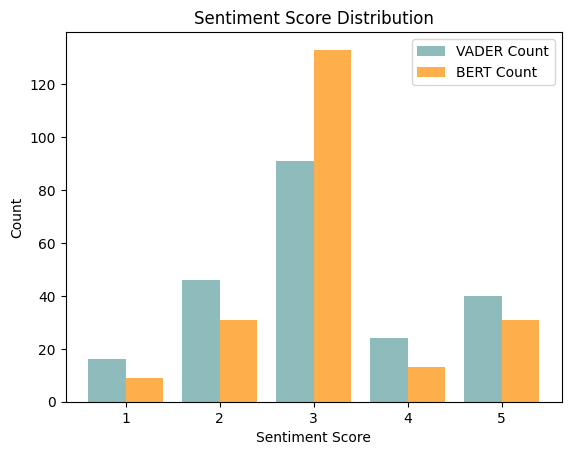

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create an array of x-coordinates for better visibility
x_vader = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
x_bert = x_vader + 0.4  # Adjust the separation between VADER and BERT bars

# Create a bar chart with both sets of bars on one set of axes
plt.bar(x_vader, table_df['VADER Count'], width=0.4, color='cadetblue', alpha=0.7, label='VADER Count')
plt.bar(x_bert, table_df['BERT Count'], width=0.4, color='darkorange', alpha=0.7, label='BERT Count')

# Set x-axis ticks and labels
plt.xticks(x_vader + 0.2, table_df['VADER Sentiment Score'])

# Set labels and title
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.title('Sentiment Score Distribution')

# # Add percentage labels to each bar
# for i, val in enumerate(table_df['VADER Percentage']):
#     plt.text(x_vader[i], table_df['VADER Count'][i] + 50, f'{val:.0%}', ha='center', va='bottom', color='black')

# for i, val in enumerate(table_df['BERT Percentage']):
#     plt.text(x_bert[i], table_df['BERT Count'][i] + 50, f'{val:.0%}', ha='center', va='bottom', color='black')

# Show legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
aoc.columns

Index(['Unnamed: 0.2', 'Document', 'Topic', 'Name', 'Representation',
       'Representative_Docs', 'Top_n_words', 'Probability',
       'Representative_document', 'vader_cont_sentiment_score',
       'vader_sentiment_score', 'bert_sentiment_score', 'uuid_x', 'source_x',
       'year_x', 'article_text_x', 'title_x', 'title_text_x', 'uuid_y',
       'source_y', 'year_y', 'article_text_y', 'title_y', 'title_text_y'],
      dtype='object')

In [ ]:
aoc_sources = aoc.groupby('source_x').size().reset_index(name='Count')
aoc_sources.rename(columns={'source_x': 'Source'}, inplace=True)

,Source,Count
0,breitbart,66
1,dailycaller,62
2,fox,45
3,npr,5
4,washtimes,39


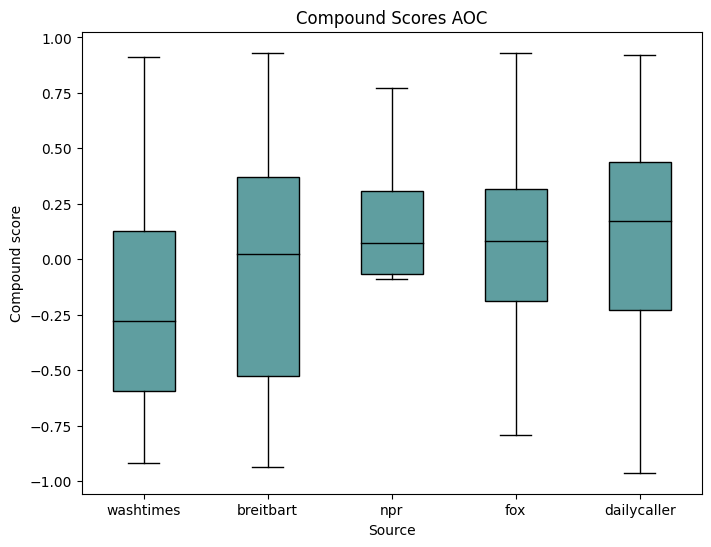

In [282]:
median_order = aoc.groupby("source_y")["vader_cont_sentiment_score"].median().sort_values().index

# Create a list of compound scores for each source
source_scores = [aoc[aoc["source_y"] == source]['vader_cont_sentiment_score'] for source in median_order]

# Create the boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(source_scores, labels=median_order, patch_artist=True, medianprops=dict(color="black"), boxprops=dict(facecolor='cadetblue'))
plt.xlabel("Source")
plt.ylabel("Compound score")
plt.title("Compound Scores AOC")
plt.show()


In [ ]:
aoc_corr = aoc[['vader_cont_sentiment_score', 'vader_sentiment_score',
       'bert_sentiment_score', 'source_x']]
aoc_corr = pd.get_dummies(aoc_corr, columns=['source_x'])

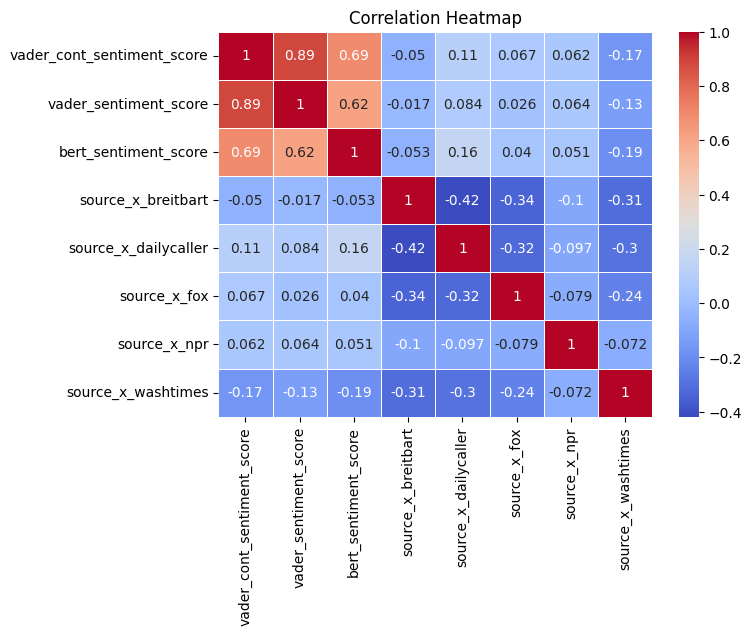

In [ ]:
# Assuming you have a DataFrame named df
correlation_matrix = aoc_corr.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

### Environment

In [ ]:
env = articles_classified[articles_classified['Topic'] == 27]

In [ ]:
env_sources = env.groupby('source_x').size().reset_index(name='Count')
env_sources.rename(columns={'source_x': 'Source'}, inplace=True)
env_sources

,Source,Count
0,breitbart,75
1,dailycaller,19
2,fox,13
3,npr,16
4,washtimes,24


In [266]:
env_avg = env.groupby('source_x').mean('vader_cont_sentiment_score').round(2)[['vader_cont_sentiment_score']]
env_sources = pd.merge(env_sources, env_avg, left_on='Source', right_on='source_x', how='inner')
env_sources.rename(columns={'vader_cont_sentiment_score': 'Avg. VADER'}, inplace=True)
env_sources

,Source,Count,Avg. VADER,Avg. VADER
0,breitbart,75,0.09,0.09
1,dailycaller,19,0.19,0.19
2,fox,13,0.07,0.07
3,npr,16,0.01,0.01
4,washtimes,24,-0.11,-0.11


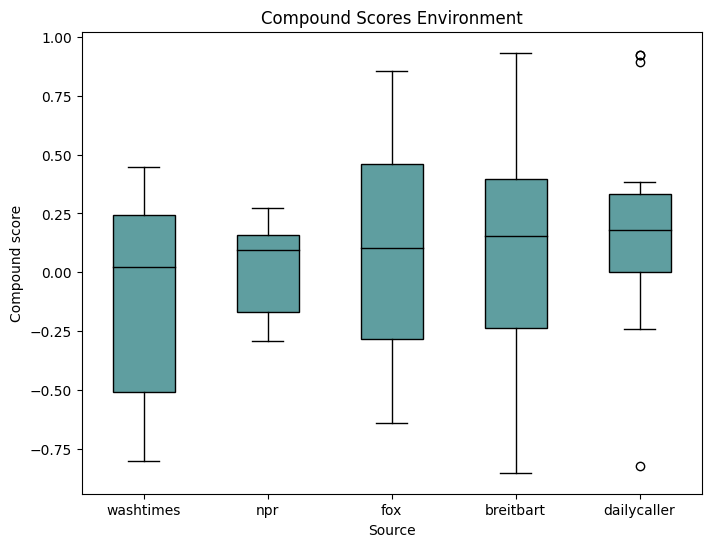

In [283]:
median_order = env.groupby("source_x")["vader_cont_sentiment_score"].median().sort_values().index

# Create a list of compound scores for each source
source_scores = [env[env["source_x"] == source]['vader_cont_sentiment_score'] for source in median_order]

# Create the boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(source_scores, labels=median_order, patch_artist=True, medianprops=dict(color="black"), boxprops=dict(facecolor='cadetblue'))
plt.xlabel("Source")
plt.ylabel("Compound score")
plt.title("Compound Scores Environment")
plt.show()

"Illegal' Immigration

In [285]:
immigration = articles_classified[articles_classified['Topic'] == 44]

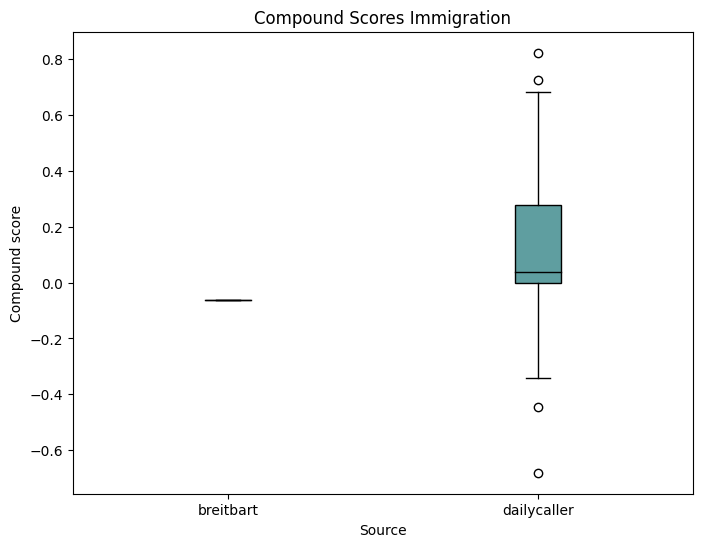

In [286]:
median_order = immigration.groupby("source_x")["vader_cont_sentiment_score"].median().sort_values().index

# Create a list of compound scores for each source
source_scores = [immigration[immigration["source_x"] == source]['vader_cont_sentiment_score'] for source in median_order]

# Create the boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(source_scores, labels=median_order, patch_artist=True, medianprops=dict(color="black"), boxprops=dict(facecolor='cadetblue'))
plt.xlabel("Source")
plt.ylabel("Compound score")
plt.title("Compound Scores Immigration")
plt.show()

### Impeachment

In [269]:
impeachment = articles_classified[articles_classified['Topic'] == 4]

In [271]:
impeachment.columns

Index(['Document', 'Topic', 'Name', 'Representation', 'Representative_Docs',
       'Top_n_words', 'Probability', 'Representative_document',
       'vader_cont_sentiment_score', 'vader_sentiment_score',
       'bert_sentiment_score', 'uuid_x', 'source_x', 'year_x',
       'article_text_x', 'title_x', 'title_text_x'],
      dtype='object')

In [280]:
impeachment = impeachment.sort_values('vader_cont_sentiment_score', ascending=False)
impeachment[:3]

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,vader_cont_sentiment_score,vader_sentiment_score,bert_sentiment_score,uuid_x,source_x,year_x,article_text_x,title_x,title_text_x
5165,"trump: ‘i’d like a trial,’ but whether there i...",4,4_impeachment_trial_articles_senate,"['impeachment', 'trial', 'articles', 'senate',...","['trump wants pelosi, schiff as impeachment wi...",impeachment - trial - articles - senate - witn...,1.000000,False,0.9253,5,4,aeb2afdd-411f-11ee-a96e-33dec8f414a2,breitbart,2020,during an interview aired on friday’s broadcas...,"trump: ‘i’d like a trial,’ but whether there i...","trump: ‘i’d like a trial,’ but whether there i..."
5468,jim jordan: senate impeachment trial to end so...,4,4_impeachment_trial_articles_senate,"['impeachment', 'trial', 'articles', 'senate',...","['trump wants pelosi, schiff as impeachment wi...",impeachment - trial - articles - senate - witn...,1.000000,False,0.8790,5,4,af10551c-411f-11ee-a96e-33dec8f414a2,breitbart,2020,during a friday interview with fox news channe...,jim jordan: senate impeachment trial to end so...,jim jordan: senate impeachment trial to end so...
18681,mcconnell: pelosi’s impeachment sign...,4,4_impeachment_trial_articles_senate,"['impeachment', 'trial', 'articles', 'senate',...","['trump wants pelosi, schiff as impeachment wi...",impeachment - trial - articles - senate - witn...,0.885004,False,0.8540,5,4,756ba892-406d-11ee-a96e-33dec8f414a2,washtimes,2020,senate majority leader mitch mcconnell called ...,mcconnell: pelosi’s impeachment sign...,mcconnell: pelosi’s impeachment sign...


In [281]:
impeachment['Document'].to_list()[:3]

['trump: ‘i’d like a trial,’ but whether there is one and its size aren’t certain during an interview aired on friday’s broadcast of the fox news channel’s “ingraham angle,” president stated that he would “like a trial” in the senate where he calls several witnesses, but also said that the length of time impeachment lasts for is dependent on “if” there is a trial and how big the trial is.trump said, “i would love to ask a couple of their people some questions, like schiff.”he also stated that the length of ti',
 'jim jordan: senate impeachment trial to end soon, american people ‘don’t seem to be tuning in’ during a friday interview with fox news channel’s “america’s newsroom,” rep. jim jordan (r-oh) sounded off on the senate impeachment trial.jordan predicted the impeachment trial, which he noted nobody is tuning into, will end in the next week so congress can get back to working for the american people.“[t]hese facts are so strong for the president, i feel real confident that hopefull

In [ ]:
impeachment_sources = impeachment['source_y'].value_counts()
impeachment_sources

breitbart      124
washtimes       78
dailycaller     70
npr             44
fox              6
bbc              1
Name: source_y, dtype: int64

In [ ]:
bert_value_counts = impeachment['bert_sentiment_score'].value_counts()
bert_value_counts[5] = 0
bert_value_counts

3    265
1     35
4     15
2      8
5      0
Name: bert_sentiment_score, dtype: int64

In [ ]:
table_df = impeachment.groupby('vader_sentiment_score').size().reset_index(name='vader_count')
table_df = table_df.sort_values('vader_sentiment_score')

In [ ]:
bert_df = impeachment.groupby('bert_sentiment_score').size().reset_index(name='bert_count')
bert_df = bert_df.sort_values('bert_sentiment_score')
bert_df = bert_df.append({'bert_sentiment_score': 5, 'bert_count': 0}, ignore_index=True)

# add bert columns
table_df['bert_sentiment_score'] = bert_df['bert_sentiment_score']
table_df['bert_count'] = bert_df['bert_count']
table_df

<ipython-input-95-0f751673596f>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bert_df = bert_df.append({'bert_sentiment_score': 5, 'bert_count': 0}, ignore_index=True)


,vader_sentiment_score,vader_count,bert_sentiment_score,bert_count
0,1,41,1,35
1,2,44,2,8
2,3,189,3,265
3,4,21,4,15
4,5,28,5,0


In [ ]:
table_df.columns

Index(['vader_sentiment_score', 'vader_count', 'bert_sentiment_score',
       'bert_count'],
      dtype='object')

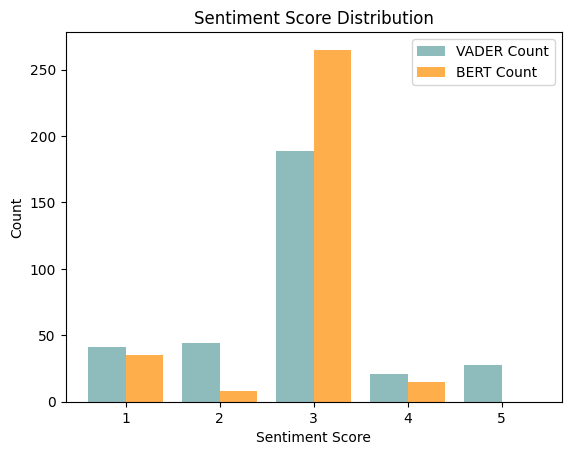

In [ ]:
# Create an array of x-coordinates for better visibility
x_vader = np.arange(len(table_df))
x_bert = x_vader + 0.4  # Adjust the separation between VADER and BERT bars

# Create a bar chart with both sets of bars on one set of axes
plt.bar(x_vader, table_df['vader_count'], width=0.4, color='cadetblue', alpha=0.7, label='VADER Count')
plt.bar(x_bert, table_df['bert_count'], width=0.4, color='darkorange', alpha=0.7, label='BERT Count')

# Set x-axis ticks and labels
plt.xticks(x_vader + 0.2, table_df['vader_sentiment_score'])

# Set labels and title
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.title('Sentiment Score Distribution')

# # Add percentage labels to each bar
# for i, val in enumerate(table_df['VADER Percentage']):
#     plt.text(x_vader[i], table_df['VADER Count'][i] + 50, f'{val:.0%}', ha='center', va='bottom', color='black')

# for i, val in enumerate(table_df['BERT Percentage']):
#     plt.text(x_bert[i], table_df['BERT Count'][i] + 50, f'{val:.0%}', ha='center', va='bottom', color='black')

# Show legend
plt.legend()

# Show the plot
plt.show()


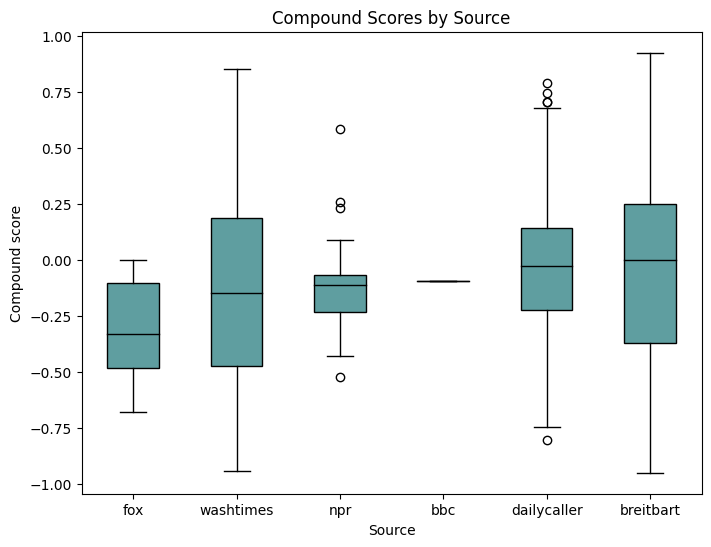

In [267]:
median_order = impeachment.groupby("source_y")["vader_cont_sentiment_score"].median().sort_values().index

# Create a list of compound scores for each source
source_scores = [impeachment[impeachment["source_y"] == source]['vader_cont_sentiment_score'] for source in median_order]

# Create the boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(source_scores, labels=median_order, patch_artist=True, medianprops=dict(color="black"), boxprops=dict(facecolor='cadetblue'))
plt.xlabel("Source")
plt.ylabel("Compound score")
plt.title("Compound Scores by Source")
plt.show()


In [ ]:
articles_classified.columns

Index(['Document', 'Topic', 'Name', 'Representation', 'Representative_Docs',
       'Top_n_words', 'Probability', 'Representative_document',
       'vader_cont_sentiment_score', 'vader_sentiment_score',
       'bert_sentiment_score', 'uuid_x', 'source_x', 'year_x',
       'article_text_x', 'title_x', 'title_text_x'],
      dtype='object')

### Top Topics

In [ ]:
total_articles = articles_classified.groupby(['source_x']).size().reset_index(name='Total Count')
total_articles = total_articles[total_articles['Total Count'] >= 30]
total_articles

,source_x,Total Count
1,breitbart,11262
2,dailycaller,5603
3,fox,2712
4,npr,1959
6,washtimes,3752


In [ ]:
num_articles = articles_classified.groupby(['Topic', 'Name', 'source_x']).size().reset_index(name='Count')

In [ ]:
num_articles = pd.merge(num_articles, total_articles, left_on='source_x', right_on='source_x', how='inner')

In [ ]:
num_articles['% of Articles'] = (num_articles['Count'] / num_articles['Total Count']).round(2)
num_articles.rename(columns={'source_x':'Source'}, inplace=True)
num_articles

,Topic,Name,Source,Count,Total Count,% of Articles
0,0,0_facebook_twitter_tech_google,breitbart,319,11262,0.03
1,1,1_mask_masks_wear_wearing,breitbart,240,11262,0.02
2,2,2_relief_package_stimulus_trillion,breitbart,78,11262,0.01
3,3,3_abortion_prolife_parenthood_abortions,breitbart,153,11262,0.01
4,4,4_impeachment_trial_articles_senate,breitbart,124,11262,0.01
...,...,...,...,...,...,...
2282,537,537_flags_halfstaff_flag_glory,washtimes,3,3752,0.00
2283,539,539_cancel_culture_rowling_jk,washtimes,3,3752,0.00
2284,540,540_haaland_deb_interior_native,washtimes,1,3752,0.00
2285,541,541_austin_dallas_abbott_texas,washtimes,1,3752,0.00


In [ ]:
num_articles = num_articles.sort_values(['Source', '% of Articles'], ascending=False)
top_topics = num_articles.groupby('Source').head(5)
top_topics

,Topic,Name,Source,Count,Total Count,% of Articles
1816,2,2_relief_package_stimulus_trillion,washtimes,132,3752,0.04
1814,0,0_facebook_twitter_tech_google,washtimes,115,3752,0.03
1818,4,4_impeachment_trial_articles_senate,washtimes,78,3752,0.02
1821,7,7_vaccine_vaccines_pfizer_doses,washtimes,69,3752,0.02
1840,26,26_pelosi_nancy_speaker_relief,washtimes,72,3752,0.02
1486,30,30_voting_cast_registration_voter,npr,71,1959,0.04
1456,0,0_facebook_twitter_tech_google,npr,65,1959,0.03
1506,51,51_census_hansi_bureau_wang,npr,64,1959,0.03
1457,1,1_mask_masks_wear_wearing,npr,38,1959,0.02
1458,2,2_relief_package_stimulus_trillion,npr,43,1959,0.02


### T-test

In [ ]:
pop_mean = num_articles['% of Articles'].mean()
pop_mean

0.0011281154350677744

In [ ]:
 num_articles[num_articles['Topic'] == 4]

,Topic,Name,Source,Count,Total Count,% of Articles
1818,4,4_impeachment_trial_articles_senate,washtimes,78,3752,0.02
1460,4,4_impeachment_trial_articles_senate,npr,44,1959,0.02
1044,4,4_impeachment_trial_articles_senate,fox,6,2712,0.00
541,4,4_impeachment_trial_articles_senate,dailycaller,70,5603,0.01
4,4,4_impeachment_trial_articles_senate,breitbart,124,11262,0.01


In [255]:
npr = num_articles.loc[num_articles['Source'] == 'npr', '% of Articles']
npr

1486    0.04
1456    0.03
1506    0.03
1457    0.02
1458    0.02
        ... 
1809    0.00
1810    0.00
1811    0.00
1812    0.00
1813    0.00
Name: % of Articles, Length: 358, dtype: float64

In [256]:
breitbart = num_articles.loc[num_articles['Source'] == 'breitbart', '% of Articles']
breitbart

0      0.03
1      0.02
5      0.02
6      0.02
10     0.02
       ... 
532    0.00
533    0.00
534    0.00
535    0.00
536    0.00
Name: % of Articles, Length: 537, dtype: float64

In [257]:
from scipy.stats import ttest_ind

# Perform a one-sample t-test
#perform independent two sample t-test
ttest_ind(npr, breitbart)

TtestResult(statistic=2.476837388422839, pvalue=0.0134394254870975, df=893.0)

In [259]:
clusters_source = articles_classified.groupby(['Topic', 'Name', 'source_x'])['vader_cont_sentiment_score'].agg(['mean', 'count']).reset_index()
clusters_source.columns = ['Topic', 'Name', 'Source', 'Average', 'Count']
clusters_source[:2]

,Topic,Name,Source,Average,Count
0,0,0_facebook_twitter_tech_google,bbc,-0.309200,1
1,0,0_facebook_twitter_tech_google,breitbart,-0.145602,319


In [264]:
npr = clusters_source.loc[(clusters_source['Source'] == 'npr'), 'Average']
breitbart = clusters_source.loc[(clusters_source['Source'] == 'breitbart'), 'Average']

In [265]:
# Perform a one-sample t-test
#perform independent two sample t-test
ttest_ind(npr, breitbart)

TtestResult(statistic=-0.11512777197255533, pvalue=0.9083697287983259, df=893.0)